In [ ]:
# Импорт библиотек
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import joblib
import time
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    roc_auc_score
)

warnings.filterwarnings("ignore")

In [ ]:
# Вспомогательные функции

# Установка сида для воспроизводимости
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Функция логирования метрик
def log_results(model_name, metrics):
    print(f"\n{model_name} Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Функция для PR-кривой
def plot_precision_recall_curve(model, X_test, y_test, model_name, ax=None):
    try:
        model.eval()
        with torch.no_grad():
            y_prob = model(torch.FloatTensor(X_test)).cpu().numpy()
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        avg_precision = average_precision_score(y_test, y_prob)

        if ax is None:
            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'Precision-Recall Curve for {model_name}')
            plt.legend(loc='best')
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'pr_curve_{model_name}.png', dpi=300)
            plt.show()
        else:
            ax.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')
        return avg_precision
    except Exception as e:
        print(f"Ошибка при построении PR-кривой для {model_name}: {e}")
        return None

In [ ]:
# Загрузка данных
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

# Выводим имена столбцов для просмотра
print("\nДоступные столбцы в датасете:")
print(df.dtypes, df.shape)

# Проверим наличие пропусков
print("\nПроверка пропущенных значений:")
print(df.isnull().sum())


Доступные столбцы в датасете:
mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points    

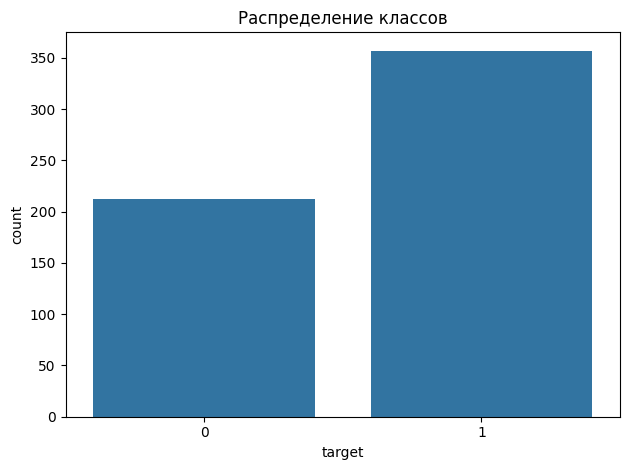

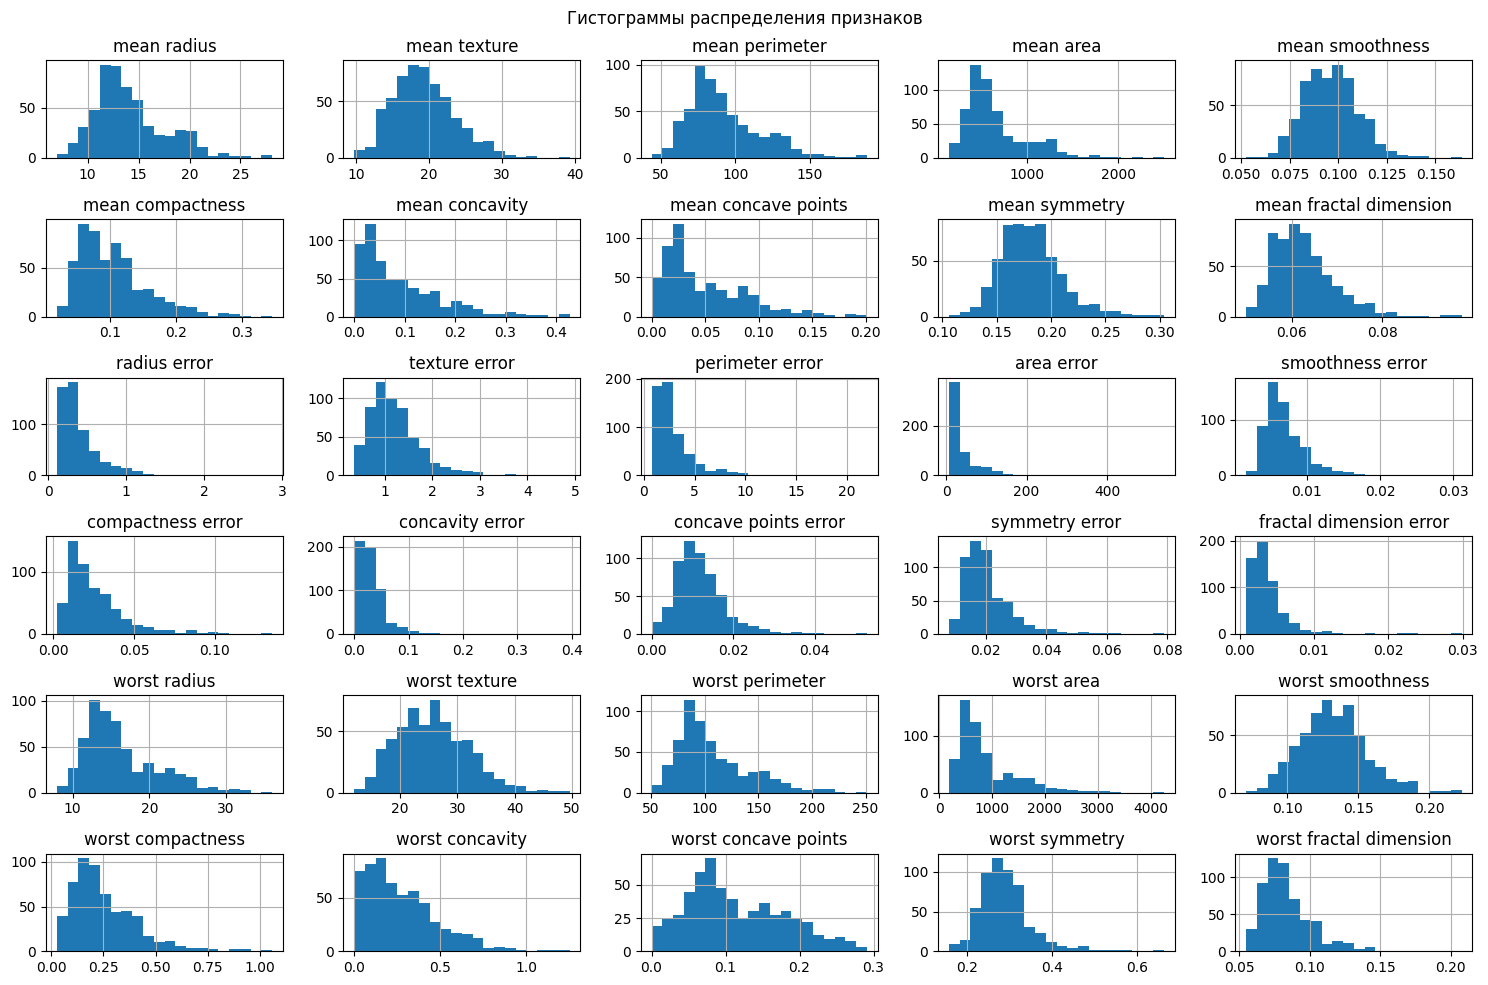

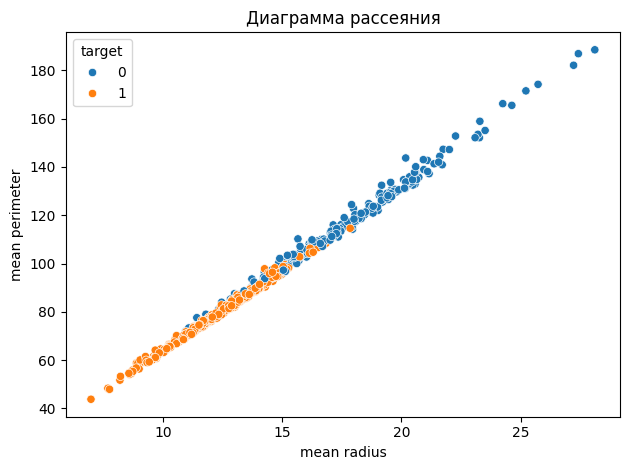

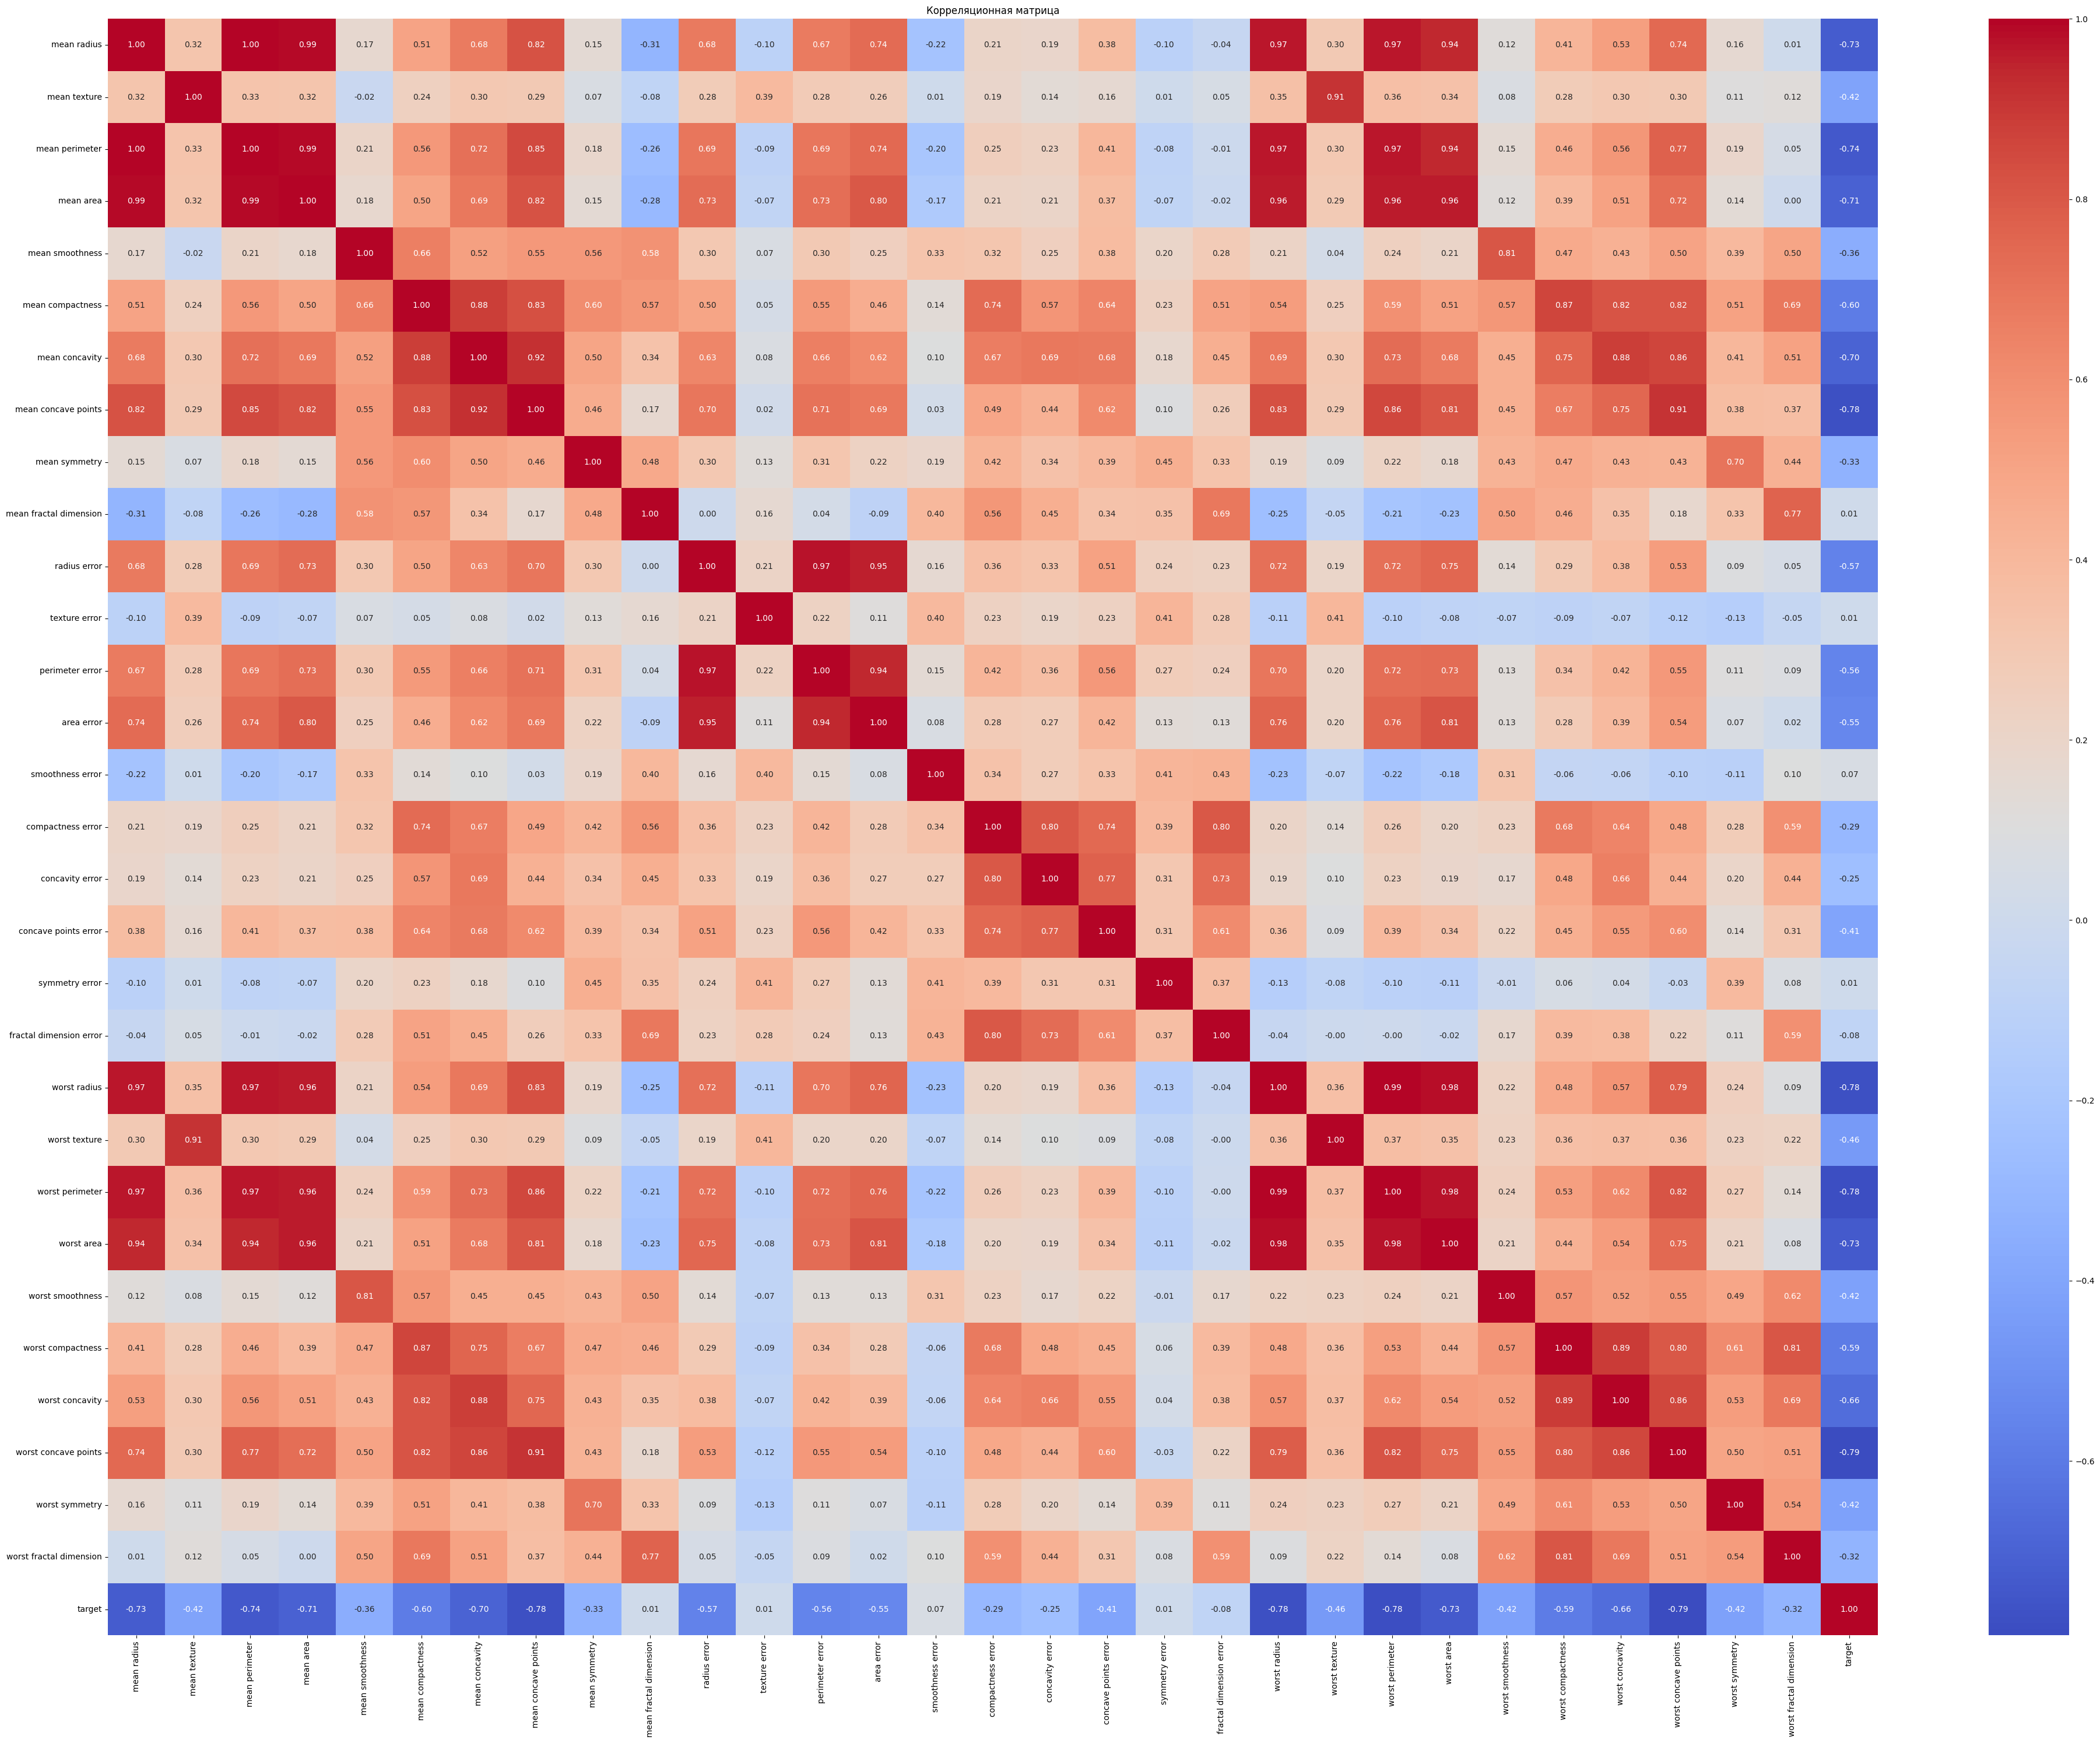

In [ ]:
# Визуализация данных

# Распределение классов
sns.countplot(x=df['target'])
plt.title('Распределение классов')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=300)
plt.show()

# Гистограммы признаков
df.drop('target', axis=1).hist(bins=20, figsize=(15, 10))
plt.suptitle('Гистограммы распределения признаков')
plt.tight_layout()
plt.savefig('histograms.png', dpi=300)
plt.show()

# Диаграмма рассеяния для двух признаков
sns.scatterplot(x=df['mean radius'], y=df['mean perimeter'], hue=df['target'])
plt.title('Диаграмма рассеяния')
plt.tight_layout()
plt.savefig('scatter_plot.png', dpi=300)
plt.show()

# Корреляционная матрица
plt.figure(figsize=(40, 30))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()


Удалено 10 признаков из-за высокой корреляции (>0.9):
['mean perimeter', 'mean area', 'mean concave points', 'perimeter error', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst concave points']


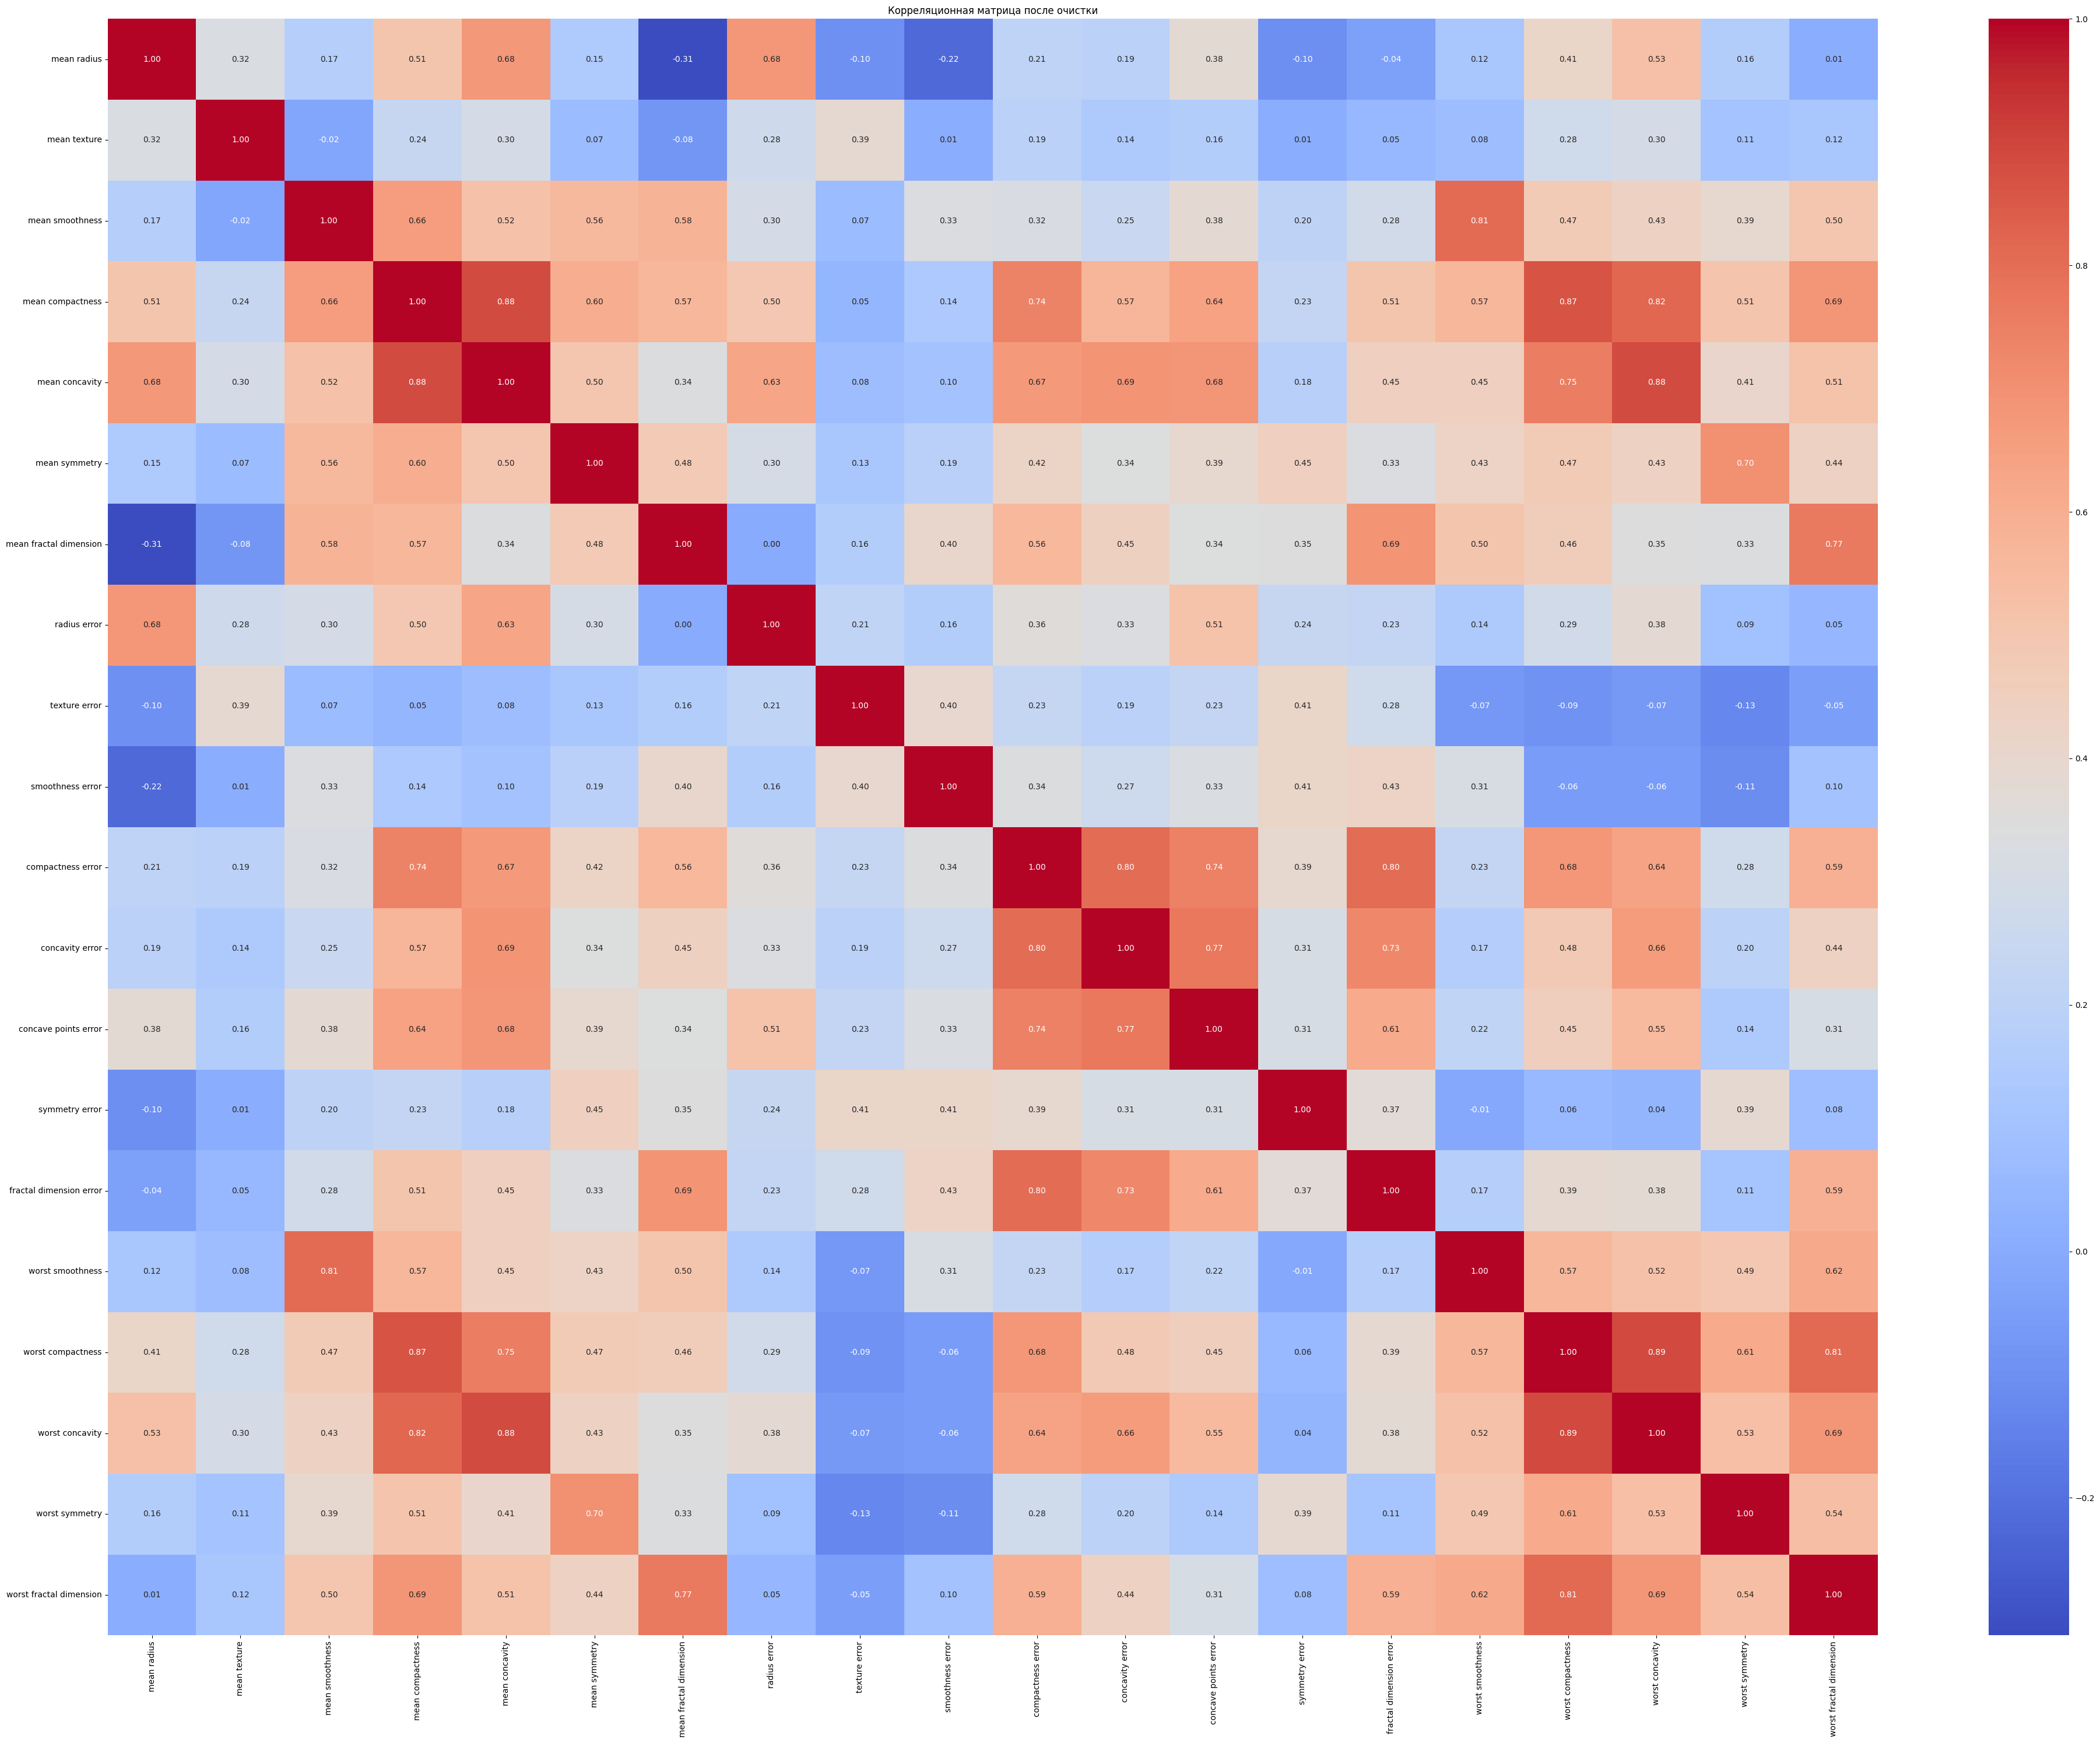

In [ ]:
# Функция удаления высоко коррелированных признаков
def remove_highly_correlated_features(dataframe, threshold=0.90):
    corr_matrix = dataframe.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    print(f"\nУдалено {len(to_drop)} признаков из-за высокой корреляции (>{threshold}):")
    print(to_drop)
    return dataframe.drop(columns=to_drop)

# Применяем очистку от корреляций
X = df.drop('target', axis=1)
y = df['target']
X_filtered = remove_highly_correlated_features(X, threshold=0.90)

# Корреляционная матрица после чистки
plt.figure(figsize=(40, 30))
correlation_matrix_filtered = X_filtered.corr()
sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица после очистки')
plt.tight_layout()
plt.savefig('correlation_matrix_filtered.png', dpi=300)
plt.show()

In [ ]:
# Разделение данных на выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Стандартизация
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Преобразование в тензоры
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

In [ ]:
# Архитектура базовой модели
class BaseNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

In [ ]:
# Архитектура улучшенной модели с гиперпараметрами
class ImprovedNet(nn.Module):
    def __init__(self, input_size, hidden1=64, hidden2=32, dropout_rate=0.3): # подбран лучший по моему мнению dropout, который минимизирует потери
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.dropout2(self.relu(self.fc2(x)))
        return self.sigmoid(self.fc3(x))

In [ ]:
# Функция обучения
def train_model(model, criterion, optimizer, X_train, y_train, epochs=160):
    start_time = time.time()
    losses = []
    set_seed(42)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch+1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Время обучения: {training_time:.2f} сек.")

    return model, losses, training_time

In [ ]:
# Функция оценки производительности
def evaluate_model(model, X_test, y_test, model_name):
    model.eval()
    with torch.no_grad():
        y_probs = model(X_test).cpu().numpy()

    y_pred = (y_probs > 0.5).astype(int)  # можно заменить на > 0.4, метрики улучшатся, но при этом на кросс-валидации будут немного хуже. Спорный вопрос!

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_probs)
    }

    log_results(model_name, metrics)

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} - Матрица ошибок")
    plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300)
    plt.show()

    # ROC-кривая
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {metrics["roc_auc"]:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model_name} - ROC-кривая")
    plt.legend()
    plt.savefig(f'roc_curve_{model_name}.png', dpi=300)
    plt.show()

    # PR-кривая
    plot_precision_recall_curve(model, X_test, y_test, model_name)

    return metrics

In [ ]:
# Инициализация моделей
set_seed(42)
input_size = X_train_scaled.shape[1]
base_model = BaseNet(input_size)
improved_model = ImprovedNet(input_size, hidden1=64, hidden2=32, dropout_rate=0.3)

In [ ]:
# Настройка обучения
criterion = nn.BCELoss()
base_optimizer = optim.Adam(base_model.parameters(), lr=0.001)
improved_optimizer = optim.AdamW(improved_model.parameters(), lr=0.001, weight_decay=1e-3)

In [ ]:
# Обучение
print("\nОбучение базовой модели:")
set_seed(42)
base_model, base_losses, base_time = train_model(
    base_model, criterion, base_optimizer, X_train_tensor, y_train_tensor
)

print("\nОбучение улучшенной модели:")
improved_model, improved_losses, improved_time = train_model(
    improved_model, criterion, improved_optimizer, X_train_tensor, y_train_tensor
)


Обучение базовой модели:
Epoch [20/160], Loss: 0.6384
Epoch [40/160], Loss: 0.5849
Epoch [60/160], Loss: 0.5037
Epoch [80/160], Loss: 0.4071
Epoch [100/160], Loss: 0.3175
Epoch [120/160], Loss: 0.2443
Epoch [140/160], Loss: 0.1893
Epoch [160/160], Loss: 0.1500
Время обучения: 0.21 сек.

Обучение улучшенной модели:
Epoch [20/160], Loss: 0.5540
Epoch [40/160], Loss: 0.3554
Epoch [60/160], Loss: 0.2120
Epoch [80/160], Loss: 0.1330
Epoch [100/160], Loss: 0.0973
Epoch [120/160], Loss: 0.0713
Epoch [140/160], Loss: 0.0637
Epoch [160/160], Loss: 0.0466
Время обучения: 0.30 сек.


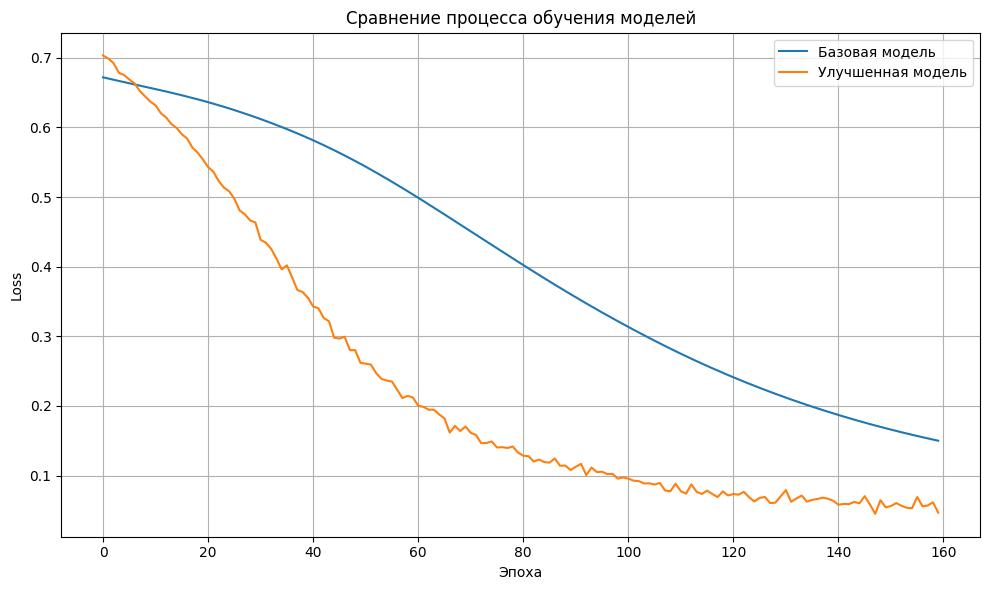

In [ ]:
# Визуализация обучения
plt.figure(figsize=(10, 6))
plt.plot(base_losses, label='Базовая модель')
plt.plot(improved_losses, label='Улучшенная модель')
plt.title('Сравнение процесса обучения моделей')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300)
plt.show()


Оценка базовой модели:

BaseNet Metrics:
accuracy: 0.9386
precision: 0.9710
recall: 0.9306
f1: 0.9504
roc_auc: 0.9897


<Figure size 800x600 with 0 Axes>

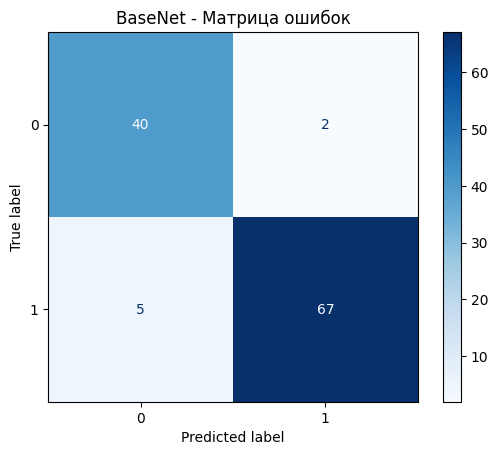

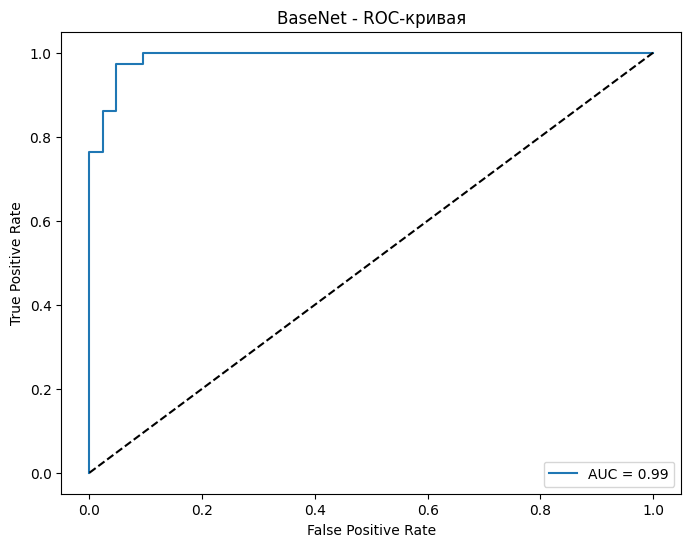

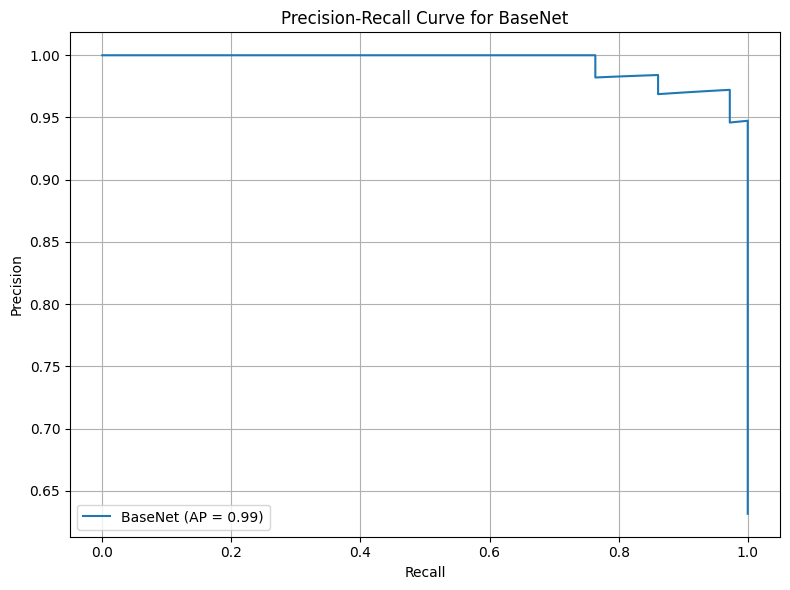


Оценка улучшенной модели:

ImprovedNet Metrics:
accuracy: 0.9649
precision: 0.9857
recall: 0.9583
f1: 0.9718
roc_auc: 0.9954


<Figure size 800x600 with 0 Axes>

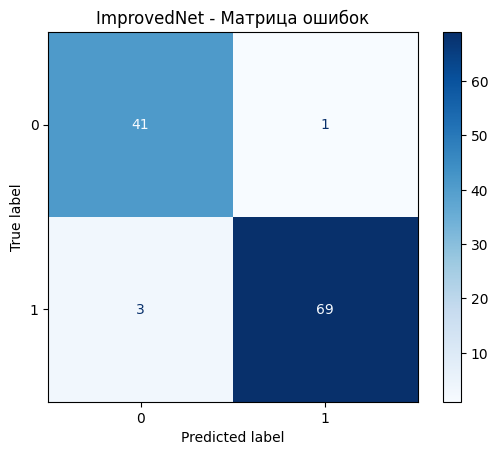

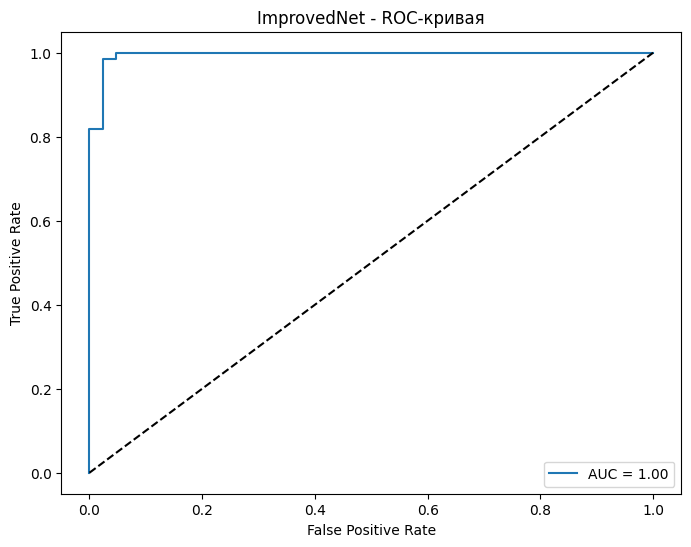

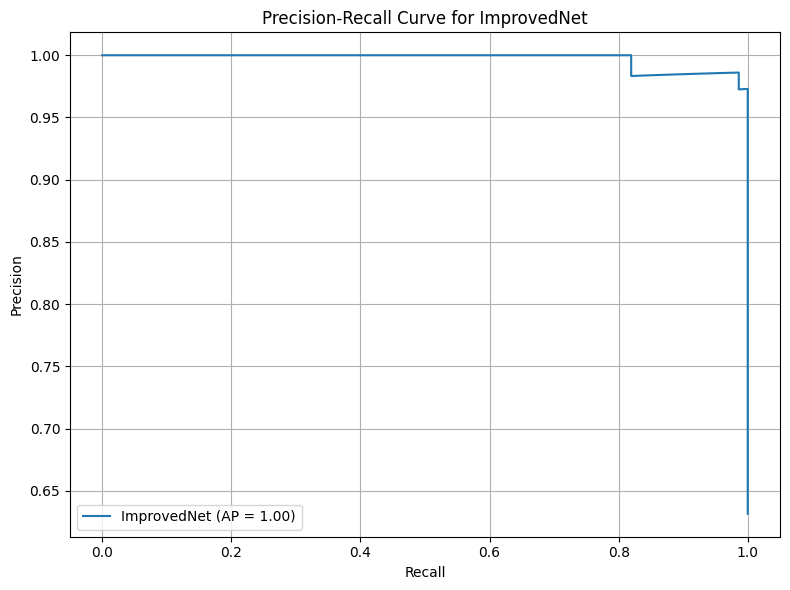

In [ ]:
# Оценка моделей
print("\nОценка базовой модели:")
base_metrics = evaluate_model(base_model, X_test_tensor, y_test, "BaseNet")

print("\nОценка улучшенной модели:")
improved_metrics = evaluate_model(improved_model, X_test_tensor, y_test, "ImprovedNet")

In [ ]:
# Кросс-валидация
def cross_validate(model_class, X, y, n_splits=5, epochs=160):
    results = {metric: [] for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'train_time']}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\nФолд {fold+1}/{n_splits}")
        set_seed(42 + fold)

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Стандартизация внутри фолда
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Преобразование в тензоры
        X_train_t = torch.FloatTensor(X_train_scaled)
        X_test_t = torch.FloatTensor(X_test_scaled)
        y_train_t = torch.FloatTensor(y_train.values).unsqueeze(1)
        y_test_t = torch.FloatTensor(y_test.values).unsqueeze(1)

        # Инициализация
        model = model_class(X_train_scaled.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3)

        # Обучение
        model, _, train_time = train_model(model, criterion, optimizer, X_train_t, y_train_t, epochs)

        # Оценка
        model.eval()
        with torch.no_grad():
            y_probs = model(X_test_t).cpu().numpy()
            y_pred = (y_probs > 0.5).astype(int)

        # Вычисление метрик
        fold_metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_probs)
        }

        for metric in fold_metrics:
            results[metric].append(fold_metrics[metric])
        results['train_time'].append(train_time)

    print("\nИтоговые результаты кросс-валидации:")
    for metric in results:
        print(f"{metric}: {np.mean(results[metric]):.4f} ± {np.std(results[metric]):.4f}")

    return results

In [ ]:
# Выполнение кросс-валидации
print("\nКросс-валидация для BaseNet:")
base_cv_results = cross_validate(BaseNet, X_filtered, y)

print("\nКросс-валидация для ImprovedNet:")
improved_cv_results = cross_validate(lambda input_size: ImprovedNet(input_size, hidden1=64, hidden2=32, dropout_rate=0.3), X_filtered, y)


Кросс-валидация для BaseNet:

Фолд 1/5
Epoch [20/160], Loss: 0.6396
Epoch [40/160], Loss: 0.5878
Epoch [60/160], Loss: 0.5085
Epoch [80/160], Loss: 0.4144
Epoch [100/160], Loss: 0.3257
Epoch [120/160], Loss: 0.2525
Epoch [140/160], Loss: 0.1976
Epoch [160/160], Loss: 0.1588
Время обучения: 0.22 сек.

Фолд 2/5
Epoch [20/160], Loss: 0.6810
Epoch [40/160], Loss: 0.6442
Epoch [60/160], Loss: 0.5869
Epoch [80/160], Loss: 0.4973
Epoch [100/160], Loss: 0.3894
Epoch [120/160], Loss: 0.2845
Epoch [140/160], Loss: 0.2066
Epoch [160/160], Loss: 0.1590
Время обучения: 0.24 сек.

Фолд 3/5
Epoch [20/160], Loss: 0.6822
Epoch [40/160], Loss: 0.6083
Epoch [60/160], Loss: 0.5040
Epoch [80/160], Loss: 0.3828
Epoch [100/160], Loss: 0.2823
Epoch [120/160], Loss: 0.2097
Epoch [140/160], Loss: 0.1602
Epoch [160/160], Loss: 0.1271
Время обучения: 0.22 сек.

Фолд 4/5
Epoch [20/160], Loss: 0.6977
Epoch [40/160], Loss: 0.6460
Epoch [60/160], Loss: 0.5644
Epoch [80/160], Loss: 0.4526
Epoch [100/160], Loss: 0.343

In [ ]:
# Сохранение моделей
torch.save(base_model,'base_model_full.pth')
torch.save(improved_model,'improved_model_full.pth')
joblib.dump(scaler, 'scaler.pkl')

# Сохранение результатов
results_dict = {
    'BaseNet': base_metrics,
    'ImprovedNet': improved_metrics
}
results_df = pd.DataFrame(results_dict).T
results_df['training_time'] = [base_time, improved_time]
results_df.to_csv('model_results.csv')

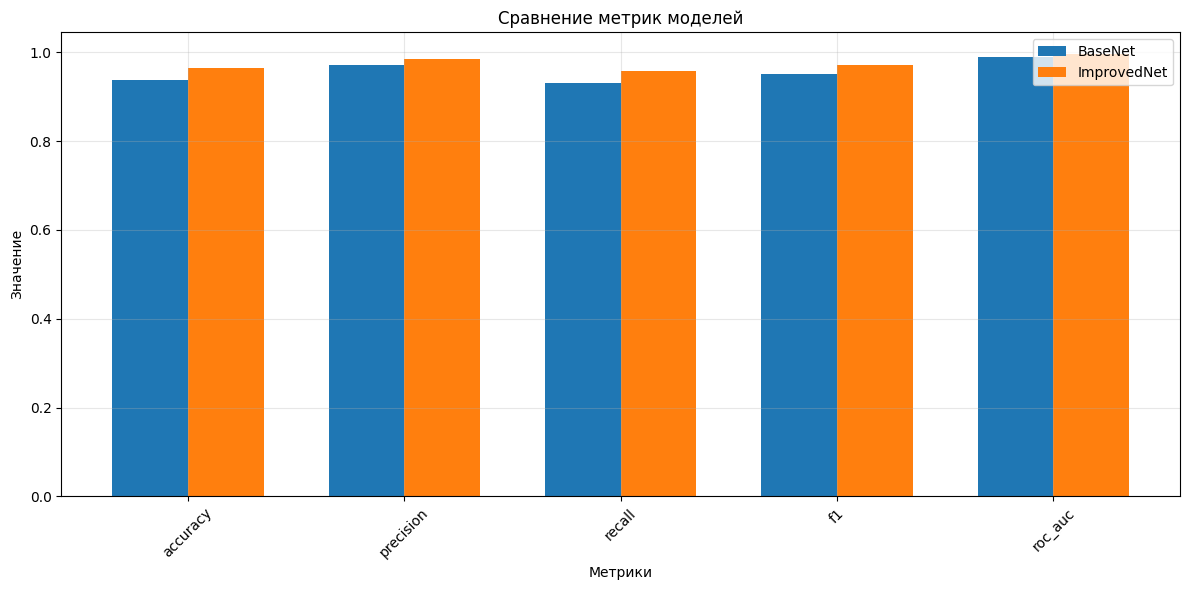

In [ ]:
# Визуализация сравнения метрик
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
plt.figure(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, [base_metrics[m] for m in metrics], width, label='BaseNet')
plt.bar(x + width/2, [improved_metrics[m] for m in metrics], width, label='ImprovedNet')

plt.xlabel('Метрики')
plt.ylabel('Значение')
plt.title('Сравнение метрик моделей')
plt.xticks(x, metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300)
plt.show()

In [ ]:
# Финальный вывод
print("\nИтоговое сравнение:")
print(f"{'Метрика':<12} {'BaseNet':<10} {'ImprovedNet':<10} {'Улучшение':<10}")
for metric in metrics:
    base_value = base_metrics[metric]
    improved_value = improved_metrics[metric]
    improvement = improved_value - base_value
    improvement_str = f"{improvement:+.4f}"
    print(f"{metric:<12} {base_value:.4f}    {improved_value:.4f}    {improvement_str}")

print("\nВремя обучения:")
print(f"BaseNet:     {base_time:.2f} сек")
print(f"ImprovedNet: {improved_time:.2f} сек")

if improved_metrics['f1'] > base_metrics['f1']:
    print("\nВывод: Улучшенная модель показывает лучшую производительность!")
else:
    print("\nВывод: Базовая модель показывает лучшую производительность!")


Итоговое сравнение:
Метрика      BaseNet    ImprovedNet Улучшение 
accuracy     0.9386    0.9649    +0.0263
precision    0.9710    0.9857    +0.0147
recall       0.9306    0.9583    +0.0278
f1           0.9504    0.9718    +0.0215
roc_auc      0.9897    0.9954    +0.0056

Время обучения:
BaseNet:     0.21 сек
ImprovedNet: 0.30 сек

Вывод: Улучшенная модель показывает лучшую производительность!
